In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt


In [2]:
test_models_dir="models"
test_scenes_dir="scenes"
test_A={
    "scenes": {"e1.png", "e2.png", "e3.png", "e4.png", "e5.png"},
    "products":{"0.jpg", "1.jpg", "11.jpg", "19.jpg", "24.jpg", "26.jpg", "25.jpg"}
}
debug=False



In [3]:
def detect(product, scene):
    # Load the query and the train images
    img_train = cv2.imread(test_scenes_dir+'/'+scene,0) # trainImage
    img_query = cv2.imread(test_models_dir+'/'+product,0) # queryImage

    # Creating SIFT object
    sift = cv2.SIFT_create()

    # Detecting Keypoints in the two images
    kp_query = sift.detect(img_query)
    kp_train = sift.detect(img_train)
    if debug:
        # Visualizing the found Keypoints
        img_visualization = cv2.drawKeypoints(img_train,kp_train,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.imshow(img_visualization)
        plt.show()
        img_visualization = cv2.drawKeypoints(img_query,kp_query,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.imshow(img_visualization)
        plt.show()

    # Computing the descriptors for each keypoint
    kp_query, des_query = sift.compute(img_query, kp_query)
    kp_train, des_train = sift.compute(img_train, kp_train)

    # Initializing the matching algorithm
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    # Matching the descriptors
    matches = flann.knnMatch(des_query,des_train,k=2)
    # Keeping only good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.5*n.distance:
            good.append(m)
            
    # If we have at least 10 matches we find the box of the object
    MIN_MATCH_COUNT = 20
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)        
        # Calculating homography based on correspondences
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        # Matches mask for visualization of only matches used by RANSAC
        matchesMask = mask.ravel().tolist()
        # Apply homography to project corners of the query image into the image
        h,w = img_query.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)      
        # Drawing bounding box
        img_train = cv2.polylines(img_train,[np.int32(dst)],True,(255,0,0),3, cv2.LINE_AA)
    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None

    # Drawing matches
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                    singlePointColor = None,
                    matchesMask = matchesMask, # draw only inliers
                    flags = 2)
    img3 = cv2.drawMatches(img_query,kp_query,img_train,kp_train,good,None,**draw_params)
    plt.imshow(img3, 'gray')
    plt.show()
    

Not enough matches are found - 0/20


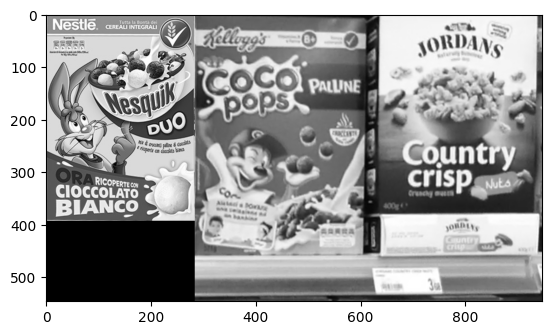

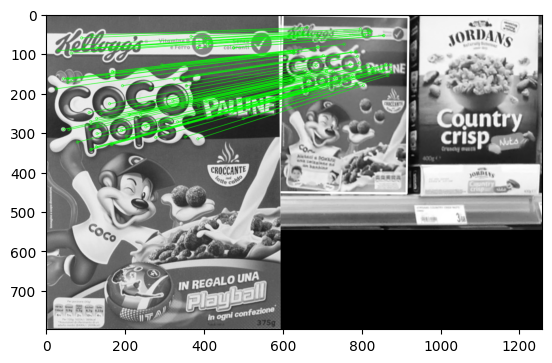

Not enough matches are found - 12/20


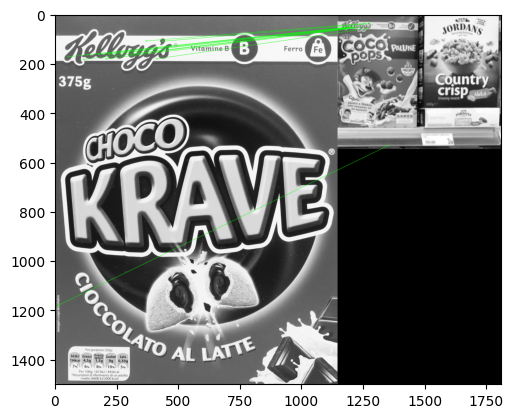

Not enough matches are found - 1/20


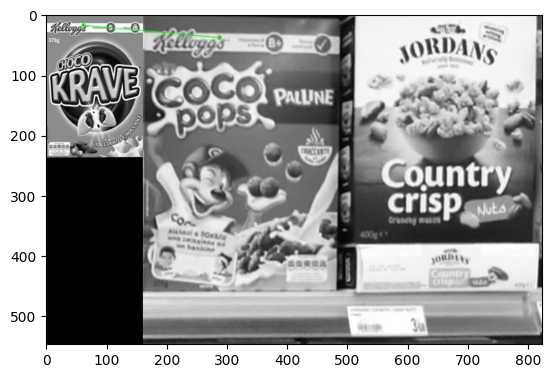

Not enough matches are found - 1/20


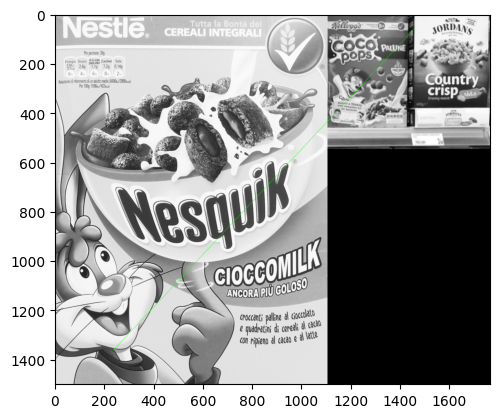

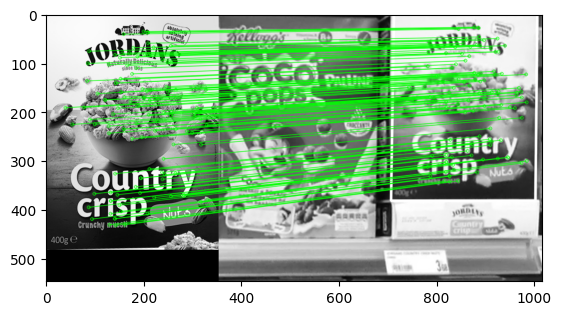

Not enough matches are found - 0/20


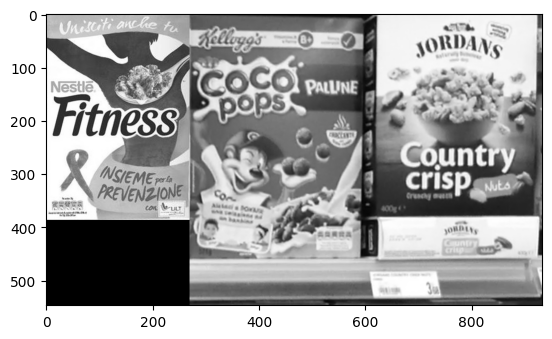

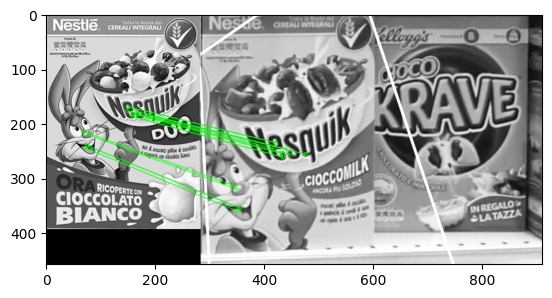

Not enough matches are found - 5/20


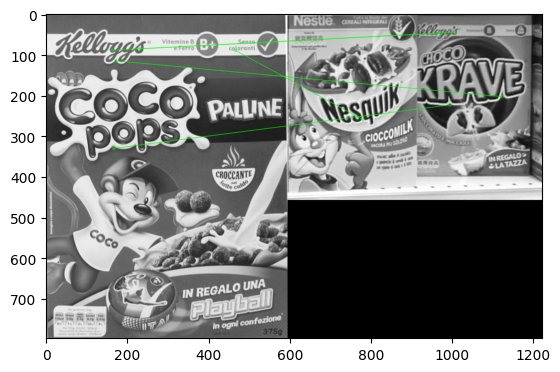

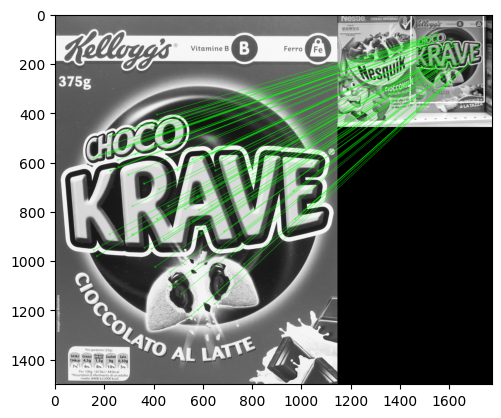

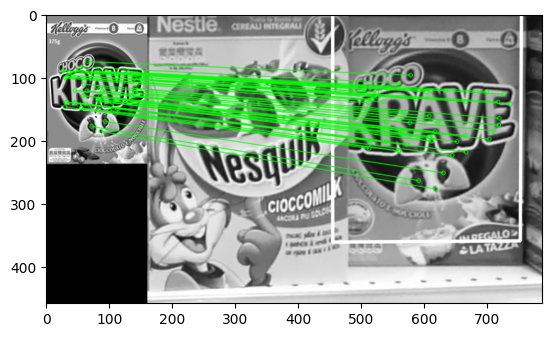

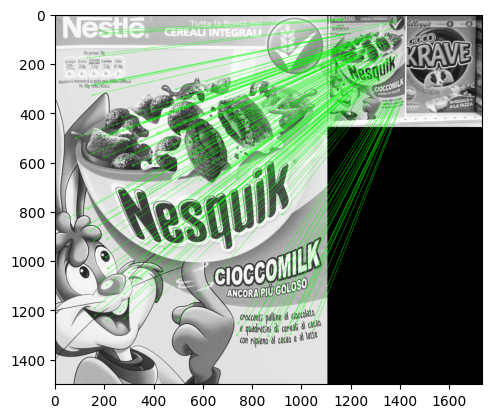

Not enough matches are found - 0/20


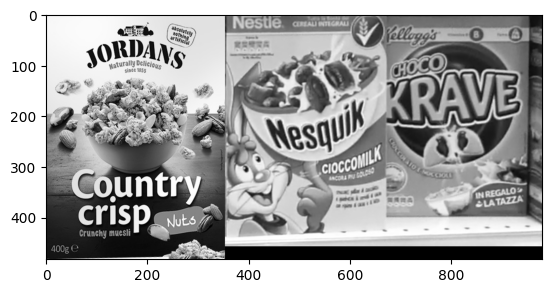

Not enough matches are found - 4/20


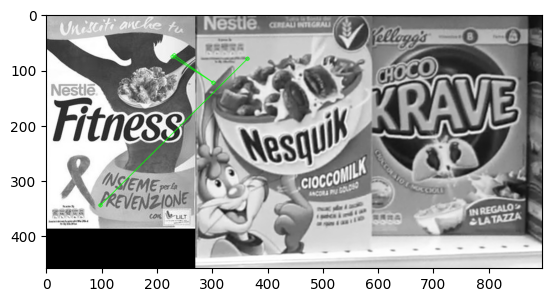

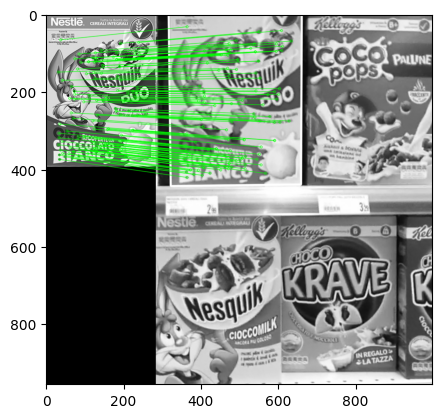

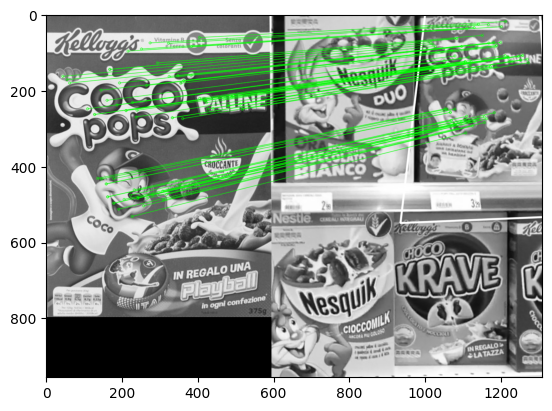

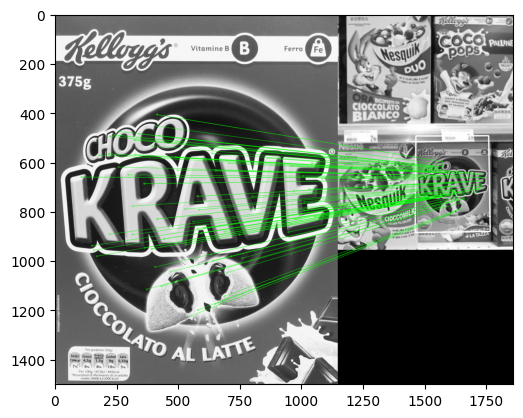

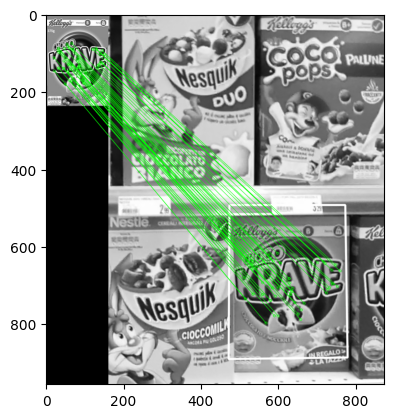

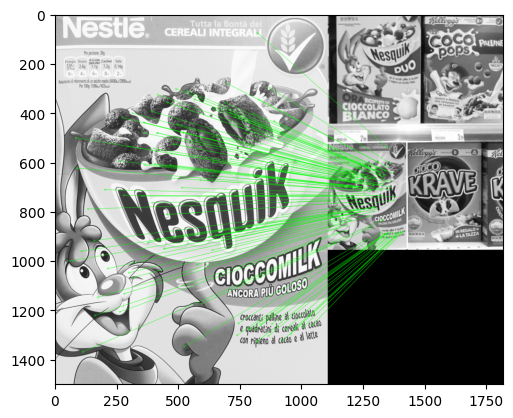

Not enough matches are found - 0/20


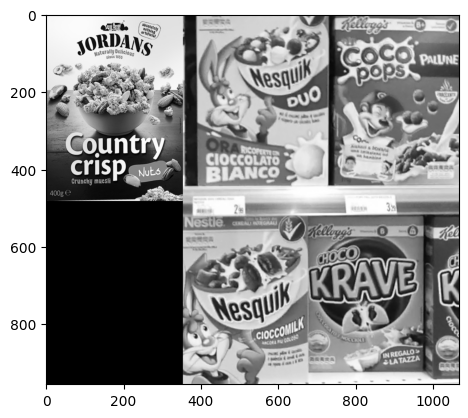

Not enough matches are found - 0/20


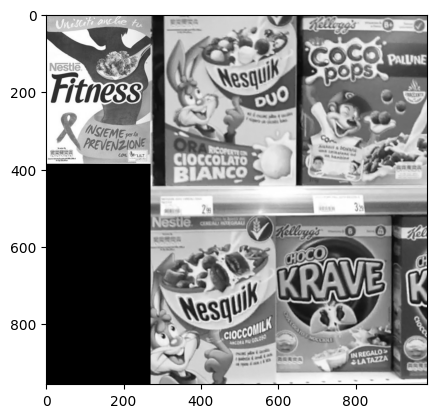

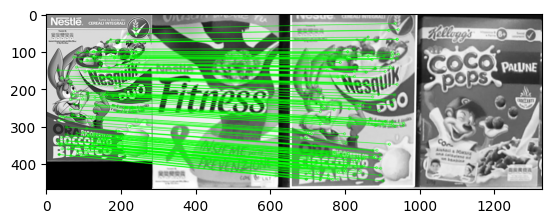

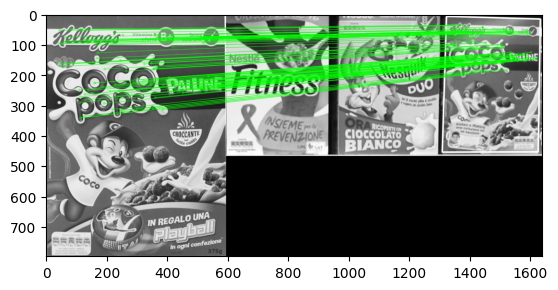

Not enough matches are found - 18/20


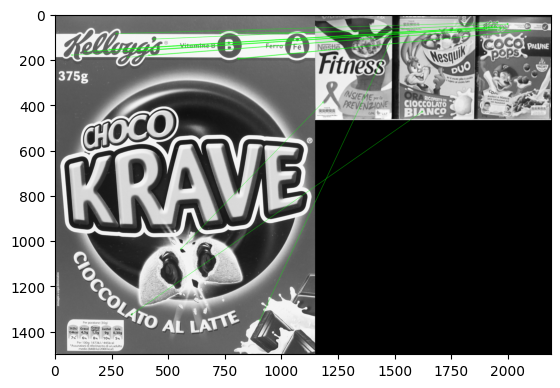

Not enough matches are found - 1/20


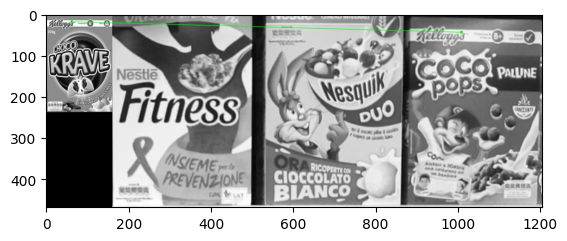

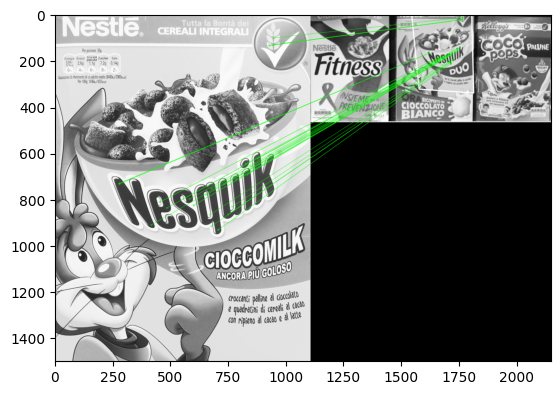

Not enough matches are found - 0/20


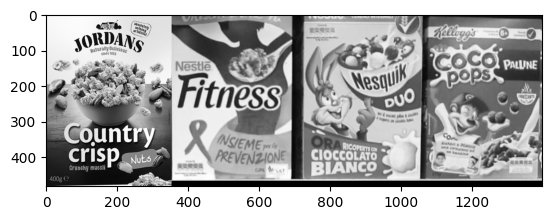

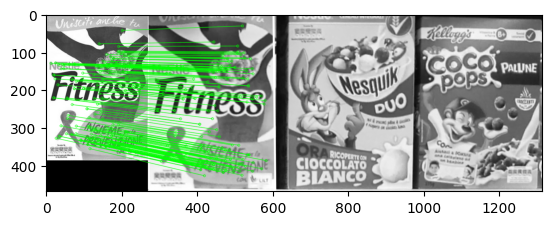

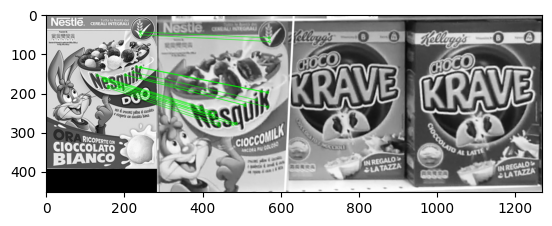

Not enough matches are found - 16/20


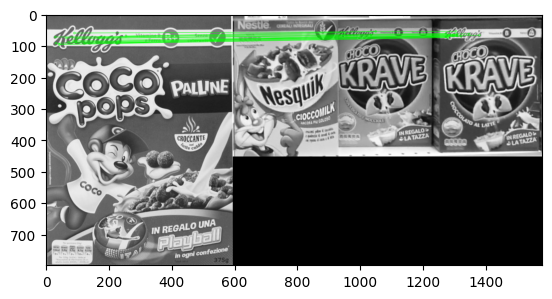

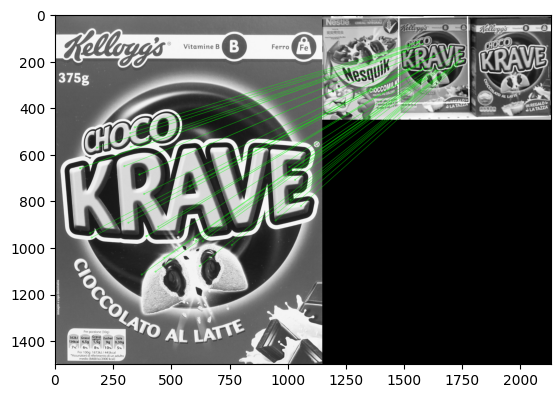

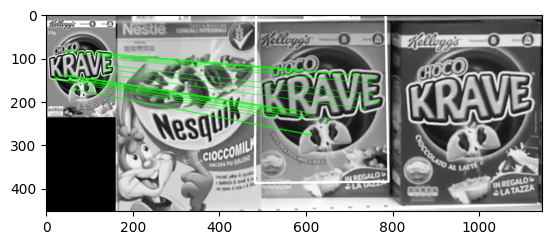

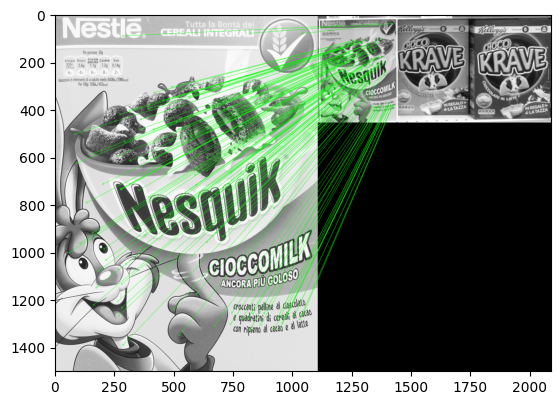

Not enough matches are found - 0/20


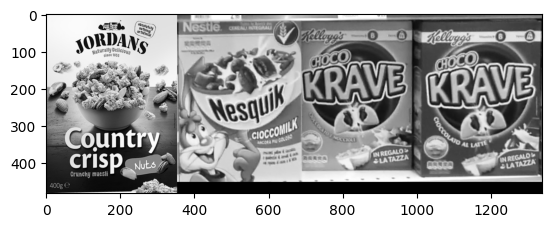

Not enough matches are found - 1/20


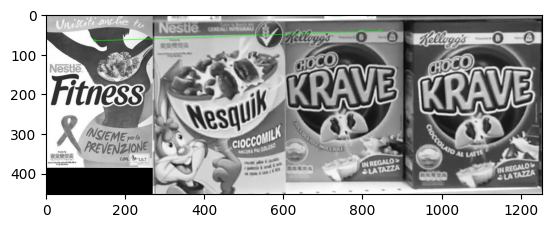

In [4]:
for s in test_A["scenes"]:
    for p in test_A["products"]:
        detect(p,s)
    

In [ ]:

#the object model acquired at training time should now consist in vectors joining all the features extracted in the model image to their
#barycenter; then, at run time all the image features matched with respect to the model would cast votes for the position of the barycenter
# by scaling appropriately the associated joining vectors (i.e. by the ratio of sizes between the matching features)
from scipy.ndimage import maximum_filter, label


def calculate_barycenter(keypoints):
    # Extract the x and y coordinates from the keypoints
    x_coords = [kp.pt[0] for kp in keypoints]
    y_coords = [kp.pt[1] for kp in keypoints]
    
    # Calculate the barycenter (centroid) coordinates
    barycenter_x = np.mean(x_coords)
    barycenter_y = np.mean(y_coords)
    
    return (barycenter_x, barycenter_y)
# Function to calculate the joining vectors from keypoints to the barycenter
def calculate_joining_vectors(keypoints, reference):
    joining_vectors = []
    
    for kp in keypoints:
        # Keypoint coordinates
        keypoint_x, keypoint_y = kp.pt
        
        # Calculate the vector from the keypoint to the barycenter
        vector_x = reference[0] - keypoint_x
        vector_y = reference[1] - keypoint_y
        
        # Append the vector to the list
        joining_vectors.append((vector_x, vector_y))
    
    return joining_vectors
      ## OFFLINE PHASE 

def offline_phase(img_model):
    # Creating SIFT object
    sift = cv2.SIFT_create(sigma = 1.6)
    # 1 - Detect kpts and compute the descriptors in the model image 
    kp_model = sift.detect(img_model)
    kp_model, des_model = sift.compute(img_model, kp_model)
    # 2 - Choose the baricenter as reference point 
    ref_point= calculate_barycenter(kp_model)
    # 3- for every feature pts calculate the joing vectoor to the refrence pts
    joning_vectors=calculate_joining_vectors(keypoints=kp_model,reference=ref_point)
    # if not debug:
    #     print(ref_point)
    #     print(joning_vectors)
    return kp_model, des_model,joning_vectors



def find_local_maxima_above_threshold(arr, threshold):
    # Create a filter that marks the local maxima
    neighborhood_size = 5  # Neighborhood size for comparison
    local_max = maximum_filter(arr, size=neighborhood_size) == arr
    
    # Exclude the borders of the array
    background = (arr == 0)
    
    # Apply the threshold condition
    threshold_mask = arr > threshold
    
    # Combine the local maxima condition with the threshold condition
    maxima_with_threshold = local_max & threshold_mask & ~background
    
    # Label the local maxima
    labeled, num_features = label(maxima_with_threshold)
    #print(num_features)
    
    # Extract the coordinates of the local maxima
    maxima_coords = np.column_stack(np.where(labeled > 0))
    
    return maxima_coords


In [ ]:

    
def draw_red_point(image, coord, radius=5, thickness=5):
    # Draw a red circle (point) on the image
    # coord is in the format (x, y)
    cv2.circle(image, coord, radius, (0, 0, 255), thickness)  # BGR color (0, 0, 255) is red in OpenCV
    cv2.imshow('Image with Red Point', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return image
## 
def online_phase(img_target,des_model,kp_model,joning_vectors,img_model):
     # Creating SIFT object
    sift = cv2.SIFT_create(sigma = 1.0)
    # 1 - Detect keypoints and compute descriptors in the target image and initialize an accumulator array, A[Pc]
    kp_target = sift.detect(img_target)
    kp_target, des_target = sift.compute(img_target, kp_target)
    # 2 - Match descriptors between target and model features
    # Initializing the matching algorithm
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    # Matching the descriptors
    matches = flann.knnMatch(des_model,des_target,k=2)
    # Keeping only good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.9*n.distance:
            good.append(m)
    # 3 - For each target feature that matches a model feature, compute the position of the reference point and 
    # cast a vote into the accumulator array
    #print("trovato "+str(len(good))+" matches")
    #dst_pts = np.int16([ kp_target[m.trainIdx].pt for m in good ])
    #TO-DO castare il voto
    #print(dst_pts)
    #print(dst_pts.shape)
    
      # Drawing matches
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                    singlePointColor = None,
                    # draw only inliers
                    flags = 2)
    # image_with_matches = cv2.drawMatches(img_model,kp_model,img_target,kp_target,good,None,**draw_params)
    # cv2.imshow('Image with Keypoints', image_with_matches)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    K=20
    n_bins=img_target.shape[1]//K
    m_bins=img_target.shape[0]//K
    accumulator_array = np.zeros((n_bins,m_bins))
    counter=0
    #print("limi: "+str(accumulator_array.shape[0])+ ":" +str(accumulator_array.shape[1]) )
    # Create a dictionary to store values with coordinates as keys
    acc_matches  = [[[] for _ in range(m_bins)] for _ in range(n_bins)]
    for m in good:
        model_pt=kp_model[m.queryIdx]
        target_pt=kp_target[m.trainIdx]
        delta_angle= np.radians(target_pt.angle-model_pt.angle)
        x_vector=joning_vectors[m.queryIdx][1]
        y_vector=joning_vectors[m.queryIdx][0]
        delta_size=target_pt.size/model_pt.size   
        #x_new = x * np.cos(angle_radians) - y * np.sin(angle_radians)
        #y_new = x * np.sin(angle_radians) + y * np.cos(angle_radians)
        x_rotated= x_vector * np.cos(delta_angle) - y_vector* np.sin(delta_angle)
        y_rotated=x_vector * np.sin(delta_angle) +  y_vector * np.cos(delta_angle)
        # print("ang:"+str(delta_angle))
        # print(delta_size)
        # print("vector: "+str(x_vector)+", "+str(y_vector))
        # print("rotated :"+str(x_rotated)+"," +str(y_rotated))
        x=round(target_pt.pt[1]+delta_size*x_rotated)
        y=round(target_pt.pt[0]+delta_size*y_rotated)
        i=y//K
        j=x//K
        if (i>=accumulator_array.shape[0] or j>=accumulator_array.shape[1] or i<=0 or j<=0):
            counter=counter+1
            #print("ij"+str(i)+":"+str(j)+" --- "+"xy"+str(x)+":"+str(y))
            continue
        accumulator_array[i][j]+=1
        acc_matches[i][j].append(m)
        #accumulator_array[x][y]=accumulator_array[x][y]+1
    #print(str(counter)+" sono fuori")
    #print(accumulator_array)
    local_maxima = find_local_maxima_above_threshold(accumulator_array,5)
    #print(np.column_stack(np.where(accumulator_array > 1)))
    #print("Local maxima coordinates:")
    return local_maxima, acc_matches, kp_target
    # for coord in local_maxima:
    #     #print(str(coord)+" "+ str(accumulator_array[coord[0]][coord[1]]))
    #     # Draw the red point on the image
    #     draw_red_point(img_target, (coord[0]*K,coord[1]*K))
    #     # Display the image (if you're running this in a local environment)
    # return 

def detectMulti(product, scene):
    
    img_bgr= cv2.imread(test_scenes_dir+'/'+scene) 
    rgb_scene = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    rgb_model = cv2.cvtColor( cv2.imread(test_models_dir+'/'+product) , cv2.COLOR_BGR2RGB)
    # Load the query and the train images
    img_train = cv2.imread(test_scenes_dir+'/'+scene,0) # trainImage
    img_model = cv2.imread(test_models_dir+'/'+product,0) # queryImage
    kp_model, des_model,joning_vectors = offline_phase(img_model=img_model)
    local_maxima, acc_matches, kp_target=online_phase(img_target=img_train,des_model=des_model,kp_model=kp_model,joning_vectors=joning_vectors,img_model=img_model)
    found=False
    for coord in local_maxima:
        #print(str(coord) +" "+ str(len(acc_matches[coord[0]][coord[1]])))
            # If we have at least 10 matches we find the box of the object
        good=acc_matches[coord[0]][coord[1]]
        MIN_MATCH_COUNT = 10
        print(len(good))
        if len(good)>MIN_MATCH_COUNT:
            found=True
            src_pts = np.float32([ kp_model[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp_target[m.trainIdx].pt for m in good ]).reshape(-1,1,2)        
            # Calculating homography based on correspondences
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            # Matches mask for visualization of only matches used by RANSAC
            matchesMask = mask.ravel().tolist()
            # Apply homography to project corners of the query image into the image
            h,w = img_model.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts,M) 
            width_box = dst[2][0][0] - dst[0][0][0]
            height_box = dst[2][0][1] - dst[0][0][1]
            x_center_box=round(dst[0][0][0]+(width_box)/2)
            y_center_box=round(dst[0][0][1]+(height_box)/2)
            #Instance 1 {position: (256,328), width: 57px, height: 80px}
            print(f"Instance {{ position: ({x_center_box},{y_center_box}), width: {round(width_box)}px, height: {round(height_box)}px}}")

            # Drawing bounding box
            rgb_scene = cv2.polylines(rgb_scene,[np.int32(dst)],True,(0,255,0),3, cv2.LINE_AA)
        else:
            #print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
            matchesMask = None
        # # Drawing matches
        # draw_params = dict(matchColor = (0,255,0), # draw matches in green color
        #                 singlePointColor = None,
        #                 matchesMask = matchesMask, # draw only inliers
        #                 flags = 2)
        # img3 = cv2.drawMatches(img_model,kp_model,img_train,kp_target,good,None,**draw_params)
        # plt.imshow(img3, 'gray')
        # plt.show()
      
         #for m in acc_matches[coord[0]][coord[1]]:
            #print(m)
    if(found):
        print("product "+product +" - "+str(len(local_maxima))+" found")
        plt.imshow(rgb_model)
        plt.show()
        plt.imshow(rgb_scene)
        plt.show()
    #test vector
    # print(kp_model[0])
    # print(kp_model[0].pt[0]+joning_vectors[0][0])
    # print(kp_model[0].pt[1]+joning_vectors[0][1])
    # END OFFLINE PHASE
    return 

detectMulti("24.jpg","m1.png")
    
    

            

    

In [ ]:
test_B={
    "scenes": {"m1.png", "m2.png", "m3.png", "m4.png", "m5.png"},
    "products":{"0.jpg", "1.jpg", "11.jpg", "19.jpg", "24.jpg", "26.jpg", "25.jpg"}
}

for s in test_B["scenes"]:
    print("---- scena "+s)
    for p in test_B["products"]:
        detectMulti(p,s)

In [ ]:
products_test_c= []
for number in range(23):
    products_test_c.append(str(number)+".jpg")
test_C={
    #{h1.png, h2.png, h3.png, h4.png, h5.png}
    #{from 0.jpg to 23.jpg}
    "scenes": {"h1.jpg", "h2.jpg", "h3.jpg", "h4.jpg", "h5.jpg"},
    "products":products_test_c
}
# detectMulti("0.jpg","h3.jpg")
for s in test_C["scenes"]:
    print("---- scena "+s)
    for p in test_C["products"]:
        detectMulti(p,s)